In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

sns.set()

## 3.3.1 Parameter Distribution

For this section we assume that $\alpha$ is also known. $\alpha$ is parameter to decide variance of prior distributionof weights $w_0$ and $w_1$ 

In [2]:
w0, w1 = -0.3, 0.5
std = 0.2
beta = (1/std**2)
alpha = 2.0

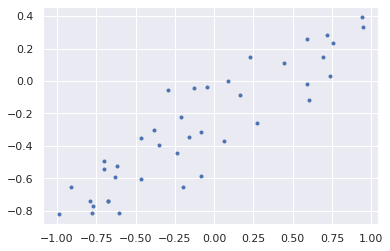

In [3]:
x = np.random.uniform(-1, 1, 100)
t = w0 + w1*x + np.random.normal(scale=std, size=100)
plt.plot(x[:40], t[:40], '.')

phi = np.ones((100, 2))
phi[:, 1] = x

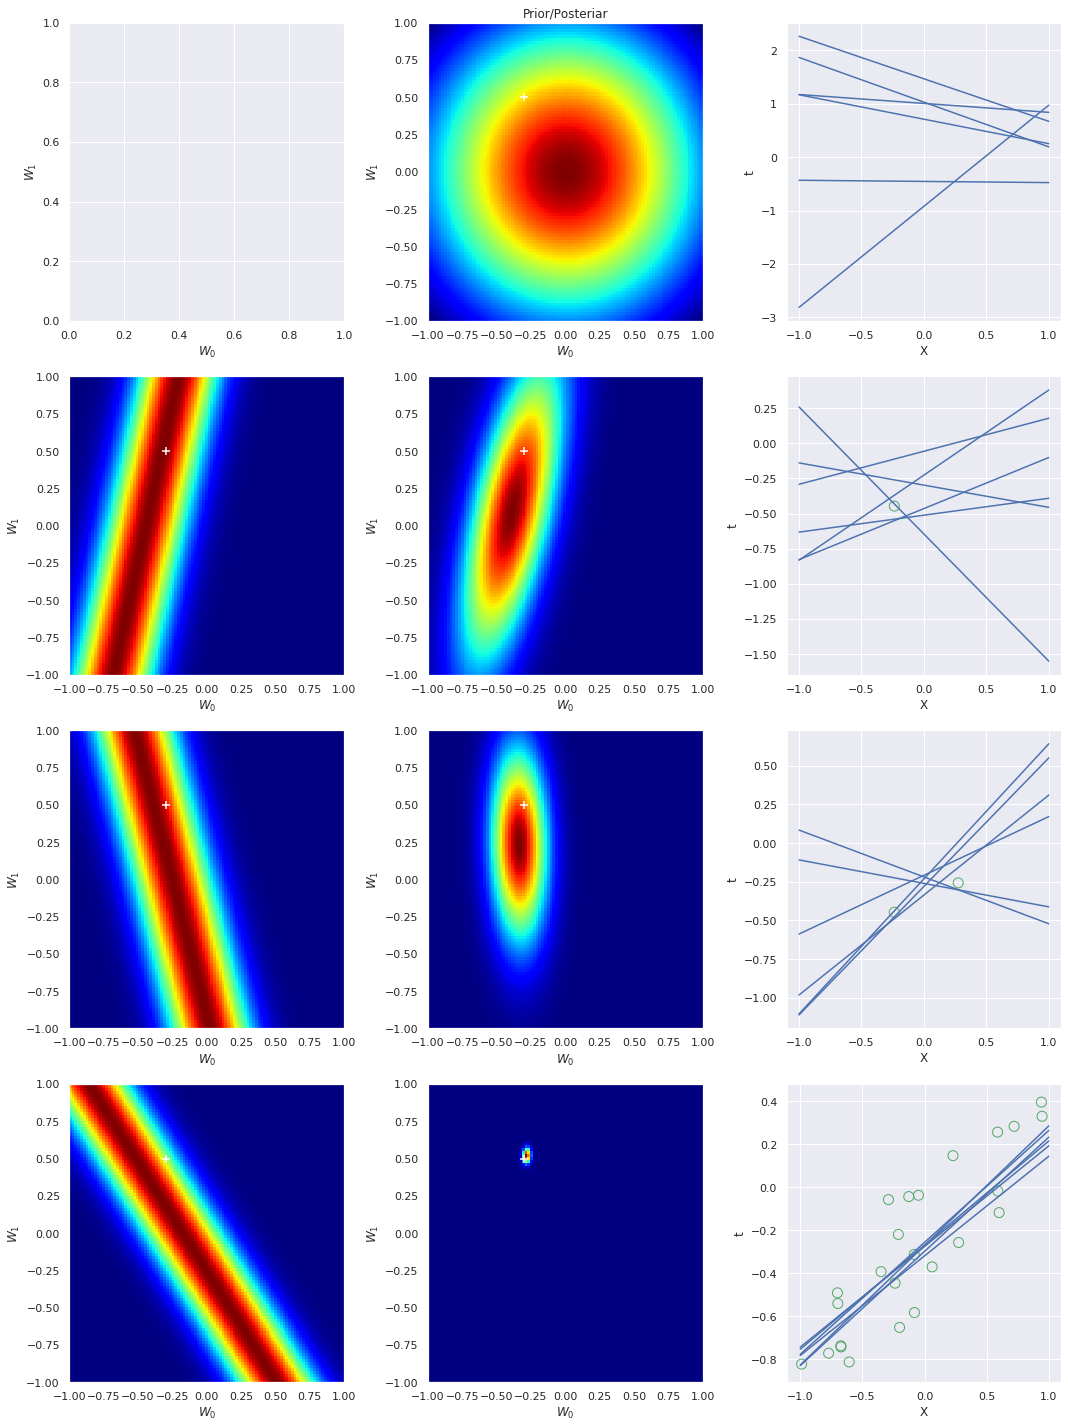

In [4]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# generate a grid to plot density functions or likelyhood on this grid
grid_w0, grid_w1 = np.mgrid[-1:1:100j, -1:1:100j]
pos = np.empty(grid_w0.shape + (2, ))
pos[:, :, 0] = grid_w0; pos[:, :, 1] = grid_w1

# prior is alpha = 2.0 => Sigma = 1/alpha * I
m_0 = [0, 0]
S_0, S_0_inv = np.eye(2)/alpha, np.eye(2)*alpha
pdf = sp.stats.multivariate_normal.pdf(pos, cov=S_0)
axs[0, 1].pcolormesh(grid_w0, grid_w1, pdf, cmap='jet')
axs[0, 1].scatter([w0], [w1], c='white', s=50, marker='+')
axs[0, 1].set_title("Prior/Posteriar")

# sample random weights from prior
w_sample = sp.stats.multivariate_normal.rvs(mean=m_0, cov=S_0, size=(6, ))
tmpx = np.linspace(-1, 1, 100)
for j in range(6):
    tmpy = tmpx * w_sample[j, 1] + w_sample[j, 0]
    axs[0, 2].plot(tmpx, tmpy, 'b')
        
# set labels for all axis in all subplots
for i in range(4):
    for j in range(2):
        axs[i, j].set_xlabel("$W_0$")
        axs[i, j].set_ylabel("$W_1$")
    axs[i, 2].set_xlabel("X")
    axs[i, 2].set_ylabel("t")
    
for i in range(0, 3):
    N = [1, 2, 100][i]  # Number of samples seen so far
    phi_, t_ = phi[:N, :], t[:N]
    
    single_phi, single_t = phi[N-1], t[N-1]
    likelyhood = np.exp((-beta/2)*(single_t - pos @ single_phi)**2)*(beta/np.sqrt(2*np.pi))
    axs[i+1, 0].pcolormesh(grid_w0, grid_w1, likelyhood, cmap='jet')
    axs[i+1, 0].scatter([w0], [w1], s=50, c='white', marker='+')
    
    S_N = np.linalg.inv(S_0_inv + beta * np.matmul(phi_.T, phi_))
    m_N = np.matmul(S_N, beta * (phi_.T @ t_))
    axs[i+1, 1].pcolormesh(grid_w0, grid_w1, sp.stats.multivariate_normal.pdf(pos, mean=m_N, cov=S_N), cmap='jet')
    axs[i+1, 1].scatter([w0], [w1], s=50, c='white', marker='+')
    
    n_to_scatter = min(25, N)  #to avoid congestion in last row, last column
    axs[i+1, 2].scatter(phi[:n_to_scatter, 1], t[:n_to_scatter], marker='o', facecolors='none', edgecolors='g', s=100)
    
    w_sample = sp.stats.multivariate_normal.rvs(mean=m_N, cov=S_N, size=(6, ))
    tmpx = np.linspace(-1, 1, 100)
    for j in range(6):
        tmpy = tmpx * w_sample[j, 1] + w_sample[j, 0]
        axs[i+1, 2].plot(tmpx, tmpy, 'b')
        
plt.tight_layout()

## 3.3.2 Predictive Distribution

First let's create few helper functios. `predictive_dist` function represents to equation 3.57 of the book. That equation uses posterier distribution (in eqauations 3.58 and 3.59), this distribution is returned by posterior_gaussian function. Here to describe whole distribution we only need mean and variance as the distribution is Gaussian.

In [5]:
def posterior_gaussian(phi, t, m_0, S_0):
    S_0_inv = np.linalg.inv(S_0)
    S_N = np.linalg.inv(S_0_inv + beta * (phi.T @ phi))
    m_N = np.matmul(S_N, beta * (phi.T @ t))
    return m_N, S_N

def predictive_dist(phi, noise_var, m_N, S_N):
    """
    Args:
        phi: Nxd design matrix
        noise_var: scalar variance in targe(assumed to be known for this section of the book)
        m_N: (d, ) array of mean for the posterior distribution of weights
        S_N: (d, d) array of variances for the posterior distribution of weights
        
    Returns:
        (mea, var) both of size (N, )
    """
    return phi @ m_N,  noise_var + (phi.T * (S_N @ phi.T)).sum(0)

In [6]:
x_for_plotting = np.linspace(0, 1, 100)

In [7]:
noise_var = 0.2
beta = 1/noise_var**2
m_0 = np.array([0]*10)
S_0 = np.eye(10)/2

Now we create a feature matrix. phi_for_plotting will 

In [8]:
radial_means, radial_var = np.linspace(0, 1, num=9), 0.1

x = np.random.uniform(0, 1, 25)
t = np.sin(2*np.pi*x) + np.random.normal(scale=noise_var, size=25)

phi = np.empty((25, 10))  # 1 column cotaining ones and other nine gaussian features
phi[:, 0] = 1
phi[:, 1:] = np.exp(-(x[:, None] - radial_means[None, :])**2/(2*radial_var))

phi_for_plotting = np.empty((100, 10))  # 1 column cotaining ones and other nine gaussian features
phi_for_plotting[:, 0] = 1
phi_for_plotting[:, 1:] = np.exp(-(x_for_plotting[:, None] - radial_means[None, :])**2/(2*radial_var))

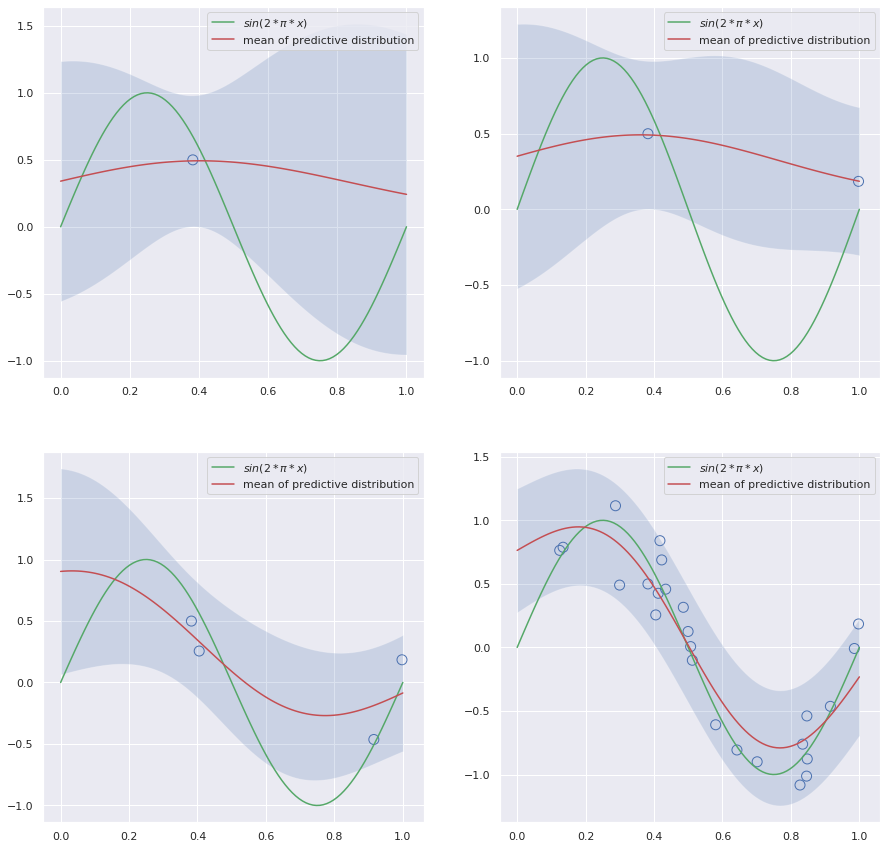

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.ravel()
for i, N in enumerate([1, 2, 4, 25]):
    m_N, S_N = posterior_gaussian(phi[:N], t[:N], m_0, S_0)
    axs[i].scatter(x[:N], t[:N], marker='o', s=100, facecolors='none', edgecolors='b')
    predictive_mean, predictive_var = predictive_dist(phi_for_plotting, noise_var, m_N, S_N)
    predictive_std = np.sqrt(predictive_var)
    one_std_lower = predictive_mean - predictive_std
    one_std_upper = predictive_mean + predictive_std

    axs[i].plot(x_for_plotting, np.sin(2*np.pi*x_for_plotting), 'g', label='$sin(2*\pi*x)$')
    axs[i].plot(x_for_plotting, predictive_mean, 'r', label='mean of predictive distribution')
    axs[i].fill_between(x_for_plotting, one_std_lower, one_std_upper, alpha=0.2)
    axs[i].legend()